# Micromagnetic standard problem 3

**Authors**: Marijan Beg

**Date**: 13 October 2016

## Problem specification

This problem is to calculate a single domain limit of a cubic magnetic particle. This is the size $L$ of equal energy for the so-called flower state (which one may also call a splayed state or a modified single-domain state) on the one hand, and the vortex or curling state on the other hand.

Geometry:

A cube with edge length, $L$, expressed in units of the intrinsic length scale, $l_\text{ex} = \sqrt{A/K_\text{m}}$, where $K_\text{m}$ is a magnetostatic energy density, $K_\text{m} = \frac{1}{2}\mu_{0}M_\text{s}^{2}$.

Material parameters: 

- uniaxial anisotropy $K_\text{u}$ with $K_\text{u} = 0.1 K_\text{m}$, and with the easy axis directed parallel to a principal axis of the cube (0, 0, 1),
- exchange energy constant is $A = \frac{1}{2}\mu_{0}M_\text{s}^{2}l_\text{ex}^{2}$.

More details about the standard problem 3 can be found in Ref. 1.

## Simulation

Firstly, we import all necessary modules.

In [1]:
import discretisedfield as df
import oommfc as oc

The following two functions are used for initialising the system's magnetisation [1].

In [2]:
import numpy as np

# Function for initiaising the flower state.
def m_init_flower(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = 2*z - 1
    mz = -2*y + 1
    norm_squared = mx**2 + my**2 + mz**2
    if norm_squared <= 0.05:
        return (1, 0, 0)
    else:
        return (mx, my, mz)

# Function for initialising the vortex state.
def m_init_vortex(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = np.sin(np.pi/2 * (x-0.5))
    mz = np.cos(np.pi/2 * (x-0.5))
    
    return (mx, my, mz)

The following function is used for convenience. It takes two arguments:

- $L$ - the cube edge length in units of $l_\text{ex}$, and
- the function for initialising the system's magnetisation.

It returns the relaxed system object.

Please refer to other tutorials for more details on how to create system objects and drive them using specific drivers.

In [3]:
def minimise_system_energy(L, m_init):
    N = 16  # discretisation in one dimension
    cubesize = 100e-9  # cube edge length (m)
    cellsize = cubesize/N  # discretisation in all three dimensions.
    lex = cubesize/L  # exchange length.
    
    Km = 1e6  # magnetostatic energy density (J/m**3)
    Ms = np.sqrt(2*Km/oc.mu0)  # magnetisation saturation (A/m)
    A = 0.5 * oc.mu0 * Ms**2 * lex**2  # exchange energy constant
    K = 0.1*Km  # Uniaxial anisotropy constant
    u = (0, 0, 1)  # Uniaxial anisotropy easy-axis

    p1 = (0, 0, 0)  # Minimum sample coordinate.
    p2 = (cubesize, cubesize, cubesize)  # Maximum sample coordinate.
    cell = (cellsize, cellsize, cellsize)  # Discretisation.
    mesh = oc.Mesh(p1=(0, 0, 0), p2=(cubesize, cubesize, cubesize),
                   cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

    system = oc.System(name="stdprob3")
    system.mesh = mesh
    system.hamiltonian = oc.Exchange(A) + oc.UniaxialAnisotropy(K, u) + oc.Demag()
    system.m = df.Field(mesh, value=m_init, normalisedto=Ms)

    md = oc.MinDriver()
    md.drive(system)
    
    return system

### Relaxed magnetisation states

Now, we show the magnetisation configurations of two relaxed states.

**Vortex** state:

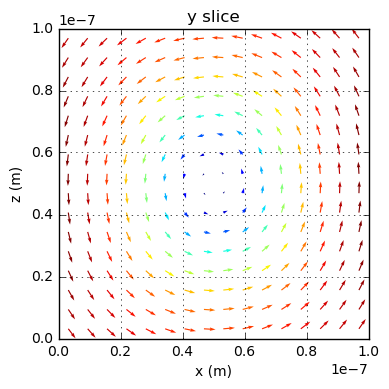

In [4]:
%matplotlib inline
system = minimise_system_energy(8, m_init_vortex)
fig = system.m.plot_slice('y', 50e-9, xsize=4)

**Flower** state:

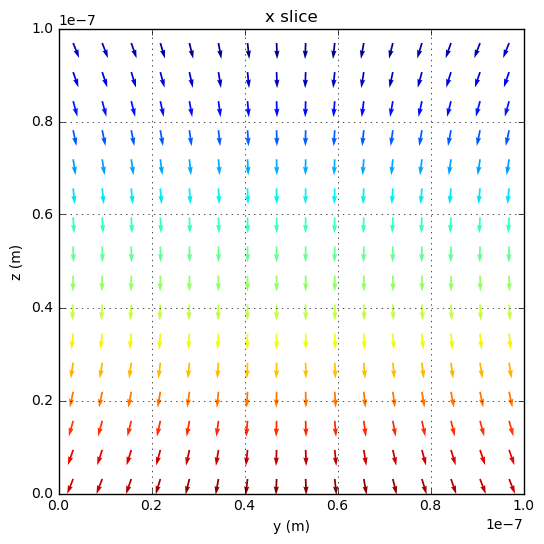

In [5]:
system = minimise_system_energy(8, m_init_flower)
fig = system.m.plot_slice('x', 50e-9, xsize=6)

### Energy crossing

Now, we can plot the energies of both vortex and flower states as a function of cube edge length. This will give us an idea where the state transition occurrs.

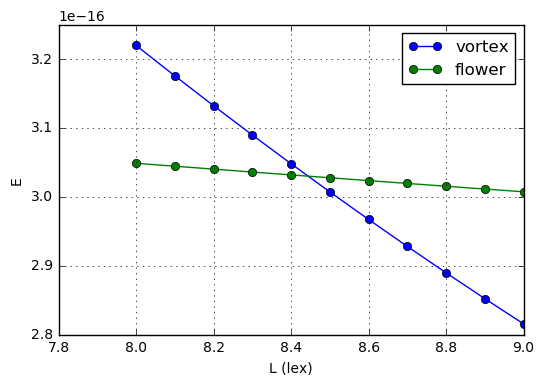

In [6]:
L_array = np.linspace(8, 9, 11)  # values of L for which the system is relaxed.

vortex_energies = []
flower_energies = []

for L in L_array:
    vortex = minimise_system_energy(L, m_init_vortex)
    flower = minimise_system_energy(L, m_init_flower)
    
    vortex_energies.append(vortex.total_energy())
    flower_energies.append(flower.total_energy())
    
# Plot the energy dependences.
import matplotlib.pyplot as plt
plt.plot(L_array, vortex_energies, 'o-', label='vortex')
plt.plot(L_array, flower_energies, 'o-', label='flower')
plt.xlabel('L (lex)')
plt.ylabel('E')
plt.grid()
plt.legend()

We now know that the energy crossing occurrs between $8l_\text{ex}$ and $9l_\text{ex}$, so a bisection algorithm can be used to find the exact crossing.

In [7]:
from scipy.optimize import bisect

def energy_difference(L):
    vortex = minimise_system_energy(L, m_init_vortex)
    flower = minimise_system_energy(L, m_init_flower)
    
    return vortex.total_energy() - flower.total_energy()

cross_section = bisect(energy_difference, 8, 9, xtol=0.1)

print("The transition between vortex and flower states occurs at {}*lex".format(cross_section))

The transition between vortex and flower states occurs at 8.4375*lex


## References
[1] µMAG Site Directory http://www.ctcms.nist.gov/~rdm/mumag.org.html